# Importing the necessary packages

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [13]:
#constants used in the particle filter
'''
num_particles : total numbers of particles
dt : time step in seconds
total_time : Total simulation time in seconds
process_noise_std : Process noise standard deviation
measurement_noise_std : Measurement noise standard deviation
g : gravitational force of gravity in meters/seconds^2
'''
num_particles = 1000
dt = 0.1  
total_time = 5  
time_steps = int(total_time / dt) #Calculation of time steps
process_noise_std = 0.1  
measurement_noise_std = 1.0  
g = 9.81 

# Intiliastion

In [14]:
# Initialize particles for two balls

particles = np.zeros((num_particles, 8))  
# 8 dimension --> [x1, y1, vx1, vy1, x2, y2, vx2, vy2] where x1,y1,vx1 and vy1 are postions and velocities of ball 1 in x and y directions and x2, y2, vx2, vy2 are postions and velocities of ball 2 in x and y directions

weights = np.ones(num_particles) / num_particles

# Launch parameters for the two balls
launch_position_ball1 = [0, 5]  # positions of ball 1 in x and y directions
launch_speed_ball1 = 10  # launch speed of ball 1 in m/s
launch_angle_ball1 = 45  # launch angle of ball 1 in degrees

launch_position_ball2 = [0, 10]  # positions of ball 2 in x and y directions
launch_speed_ball2 = 15  # launch speed of ball 2 in m/s
launch_angle_ball2 = 30  # launch angle of ball 2 in degrees

# Convert launch angles of balls to radians
launch_angle_rad_ball1 = np.radians(launch_angle_ball1)
launch_angle_rad_ball2 = np.radians(launch_angle_ball2)


'''
Initial state for the two balls based on launch parameters.
Intial state:[x,y,vx0,vy0] where x and y positions in x and y directions and vx0 and vy0 are accelerations in x and y directions
'''
initial_state_ball1 = [
    launch_position_ball1[0],
    launch_position_ball1[1],
    launch_speed_ball1 * np.cos(launch_angle_rad_ball1),
    launch_speed_ball1 * np.sin(launch_angle_rad_ball1)
]
initial_state_ball2 = [
    launch_position_ball2[0],
    launch_position_ball2[1],
    launch_speed_ball2 * np.cos(launch_angle_rad_ball2),
    launch_speed_ball2 * np.sin(launch_angle_rad_ball2)
]

# Initializing the particles around the initial state with added noise(i.e process_noise_std)
particles[:, 0:4] = initial_state_ball1 + np.random.normal(0, process_noise_std, (num_particles, 4)) #particles[:, 0:4] considers the first 4 column values(i.e values of ball 1)
particles[:, 4:8] = initial_state_ball2 + np.random.normal(0, process_noise_std, (num_particles, 4)) #particles[:, 4:8] considers the rest 4 column values (i.e values of ball 2)


# Trajectory simulation

In [15]:


# Initialize true positions of balls
true_positions_ball1 = np.zeros((time_steps, 2))
true_positions_ball2 = np.zeros((time_steps, 2))
true_positions_ball1[0] = initial_state_ball1[:2]
true_positions_ball2[0] = initial_state_ball2[:2]

# Initialize true velocities for the balls
true_velocities_ball1 = np.zeros((time_steps, 2))
true_velocities_ball2 = np.zeros((time_steps, 2))
true_velocities_ball1[0] = initial_state_ball1[2:4]
true_velocities_ball2[0] = initial_state_ball2[2:4]

# Generate noisy observations
observed_positions = np.zeros((time_steps, 2, 2))  # [time, ball, coordinates]
#print(time_steps)
for t in range(1, time_steps):
    #print(t)
    # Calculating the true positions and velocities using projectile motion equations.
    true_positions_ball1[t, 0] = true_positions_ball1[t-1, 0] + true_velocities_ball1[t-1, 0] * dt
    true_positions_ball1[t, 1] = true_positions_ball1[t-1, 1] + true_velocities_ball1[t-1, 1] * dt - 0.5 * g * dt**2
    true_velocities_ball1[t, 0] = true_velocities_ball1[t-1, 0]
    true_velocities_ball1[t, 1] = true_velocities_ball1[t-1, 1] - g * dt
    
    true_positions_ball2[t, 0] = true_positions_ball2[t-1, 0] + true_velocities_ball2[t-1, 0] * dt
    true_positions_ball2[t, 1] = true_positions_ball2[t-1, 1] + true_velocities_ball2[t-1, 1] * dt - 0.5 * g * dt**2
    true_velocities_ball2[t, 0] = true_velocities_ball2[t-1, 0]
    true_velocities_ball2[t, 1] = true_velocities_ball2[t-1, 1] - g * dt
    

    # Simulate observation dropouts (e.g., between t=6 and t=15)
    if(6<t<15):
        observed_positions[t, 0] = [np.nan, np.nan]
        observed_positions[t, 1] = [np.nan, np.nan]
    else:    
        observed_positions[t, 0] = true_positions_ball1[t] + np.random.normal(0, measurement_noise_std, 2)
        observed_positions[t, 1] = true_positions_ball2[t] + np.random.normal(0, measurement_noise_std, 2)
#print(observed_positions)


# The 3 functions of particle filter : prediction, updation and resampling

In [16]:
'''Prediction function:
Input values 
particles: a 2D array with intialised values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2
dt : time difference
process_noise_std : a process noise std 

It updates position of balls based on velocity and add process noise 
'''

def prediction(particles, dt, process_noise_std):
    # Update position based on velocity and add process noise
    particles[:, 0] += particles[:, 2] * dt + np.random.normal(0, process_noise_std, num_particles)  # calculating the x1
    particles[:, 1] += particles[:, 3] * dt - 0.5 * g * dt**2 + np.random.normal(0, process_noise_std, num_particles)  # calculating the y1
    particles[:, 2] += np.random.normal(0, process_noise_std, num_particles)  # calculating the vx1
    particles[:, 3] += -g * dt + np.random.normal(0, process_noise_std, num_particles)  # calculating the vy1
    
    particles[:, 4] += particles[:, 6] * dt + np.random.normal(0, process_noise_std, num_particles)  #calculating the x2
    particles[:, 5] += particles[:, 7] * dt - 0.5 * g * dt**2 + np.random.normal(0, process_noise_std, num_particles)  # calculating they2
    particles[:, 6] += np.random.normal(0, process_noise_std, num_particles)  # calculating the vx2
    particles[:, 7] += -g * dt + np.random.normal(0, process_noise_std, num_particles)  # calculating the vy2


In [17]:
'''Update function
Arguments:
particles : a 2D array of calculated values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2 from prediction function
weights : weights values
measurments : the observed positions of balls
measurement_noise_std : a measurement noise std value

'''

# Update function with handling for observation dropouts
def update(particles, weights, measurements, measurement_noise_std):
    for i in range(2):  # Iterate over two balls
        if not np.isnan(measurements[i, 0]):
            distance = np.linalg.norm(particles[:, 4*i:4*i+2] - measurements[i], axis=1)
            weights *= np.exp(-0.5 * (distance / measurement_noise_std)**2)
        else:
            weights[:] = 1.0 / len(weights)  # Uniform weights if observation is NaN
    
    weights += 1.e-300  # Avoid division by zero
    weights /= np.sum(weights)  # Normalize weights

    return weights


In [18]:
'''Resampling function

Arguments:
particles :  a 2D array of calculated values for [x1,y1,vx1,vy1,x2,y2,vx2,vy2] of ball 1 and 2 from prediction function
weights : The weights caluclated from updation function
'''
def resampling(particles, weights):
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    particles = particles[indices]
    weights = weights[indices]
    weights /= np.sum(weights)  # Normalize weights
    return particles, weights


# Running the particle filter.

In [19]:



#intialising the estimated positions for balls
estimated_positions_ball1 = np.zeros((time_steps, 2))
estimated_positions_ball2 = np.zeros((time_steps, 2))

estimated_velocities_ball1 = np.zeros((time_steps,2))
estimated_velocities_ball2 = np.zeros((time_steps,2))

for t in range(time_steps):
    if t > 0:
        prediction(particles, dt, process_noise_std)
    
    weights = update(particles, weights, observed_positions[t], measurement_noise_std)
    particles, weights = resampling(particles, weights)
    
    # Estimating the position as the weighted mean of the particles
    estimated_positions_ball1[t] = np.average(particles[:, 0:2], weights=weights, axis=0)
    estimated_positions_ball2[t] = np.average(particles[:, 4:6], weights=weights, axis=0)
    
    # Estimating the velocity as the weighted mean of the particles' velocities
    estimated_velocities_ball1[t] = np.average(particles[:, 2:4], weights=weights, axis=0)
    estimated_velocities_ball2[t] = np.average(particles[:, 6:8], weights=weights, axis=0)





# Plotting the results

C:\Users\anagh\AppData\Local\Temp\ipykernel_7112\1419714713.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(observed_positions[:, 0, 0], observed_positions[:, 0, 1], 'x', label='Observed Position Ball 1', linestyle='none', marker='x')
C:\Users\anagh\AppData\Local\Temp\ipykernel_7112\1419714713.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(observed_positions[:,1,0], observed_positions[:, 1, 1], 'x', label='Observed Position Ball 2',linestyle='none', marker='x')


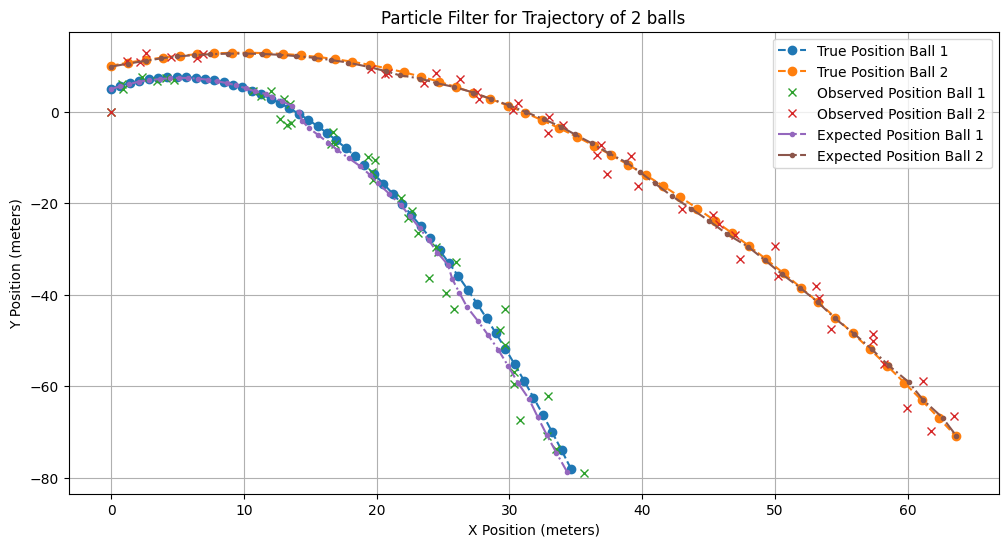

In [20]:
# Plot the results of true positions of ball1 and ball2, observed positions of ball 1.
plt.figure(figsize=(12, 6))
plt.plot(true_positions_ball1[:, 0], true_positions_ball1[:, 1], label='True Position Ball 1', linestyle='--',marker='o')
plt.plot(true_positions_ball2[:, 0], true_positions_ball2[:, 1], label='True Position Ball 2', linestyle='--',marker='o')
plt.plot(observed_positions[:, 0, 0], observed_positions[:, 0, 1], 'x', label='Observed Position Ball 1', linestyle='none', marker='x')
plt.plot(observed_positions[:,1,0], observed_positions[:, 1, 1], 'x', label='Observed Position Ball 2',linestyle='none', marker='x')
plt.plot(estimated_positions_ball1[:, 0], estimated_positions_ball1[:, 1], label='Expected Position Ball 1', linestyle='-.',marker='.')
plt.plot(estimated_positions_ball2[:, 0], estimated_positions_ball2[:, 1], label='Expected Position Ball 2', linestyle='-.',marker='.')
plt.legend()
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('Particle Filter for Trajectory of 2 balls')
plt.grid(True)
plt.show()

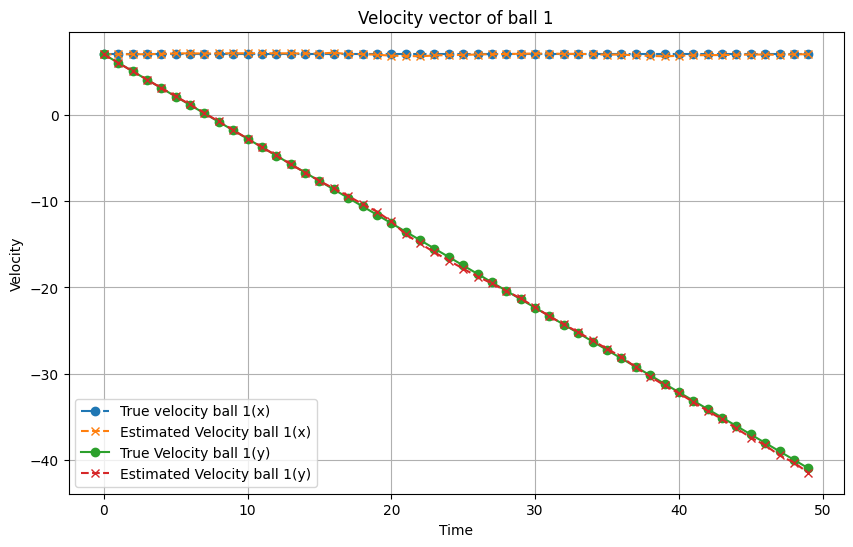

In [21]:
# Plotting the results using matplotlib
# plotting the true velocities, and estimated velocities of ball 1

plt.figure(figsize=(10, 6))
plt.plot(range(len(true_velocities_ball1)), true_velocities_ball1[:, 0], label='True velocity ball 1(x)', linestyle='-.', marker='o')
plt.plot(range(len(true_velocities_ball1)), estimated_velocities_ball1[:, 0], label='Estimated Velocity ball 1(x)', linestyle='--', marker='x')
plt.plot(range(len(true_positions_ball1)), true_velocities_ball1[:, 1], label='True Velocity ball 1(y)', linestyle='-', marker='o')
plt.plot(range(len(true_velocities_ball1)), estimated_velocities_ball1[:, 1], label='Estimated Velocity ball 1(y)', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vector of ball 1')
plt.grid(True)
plt.show()

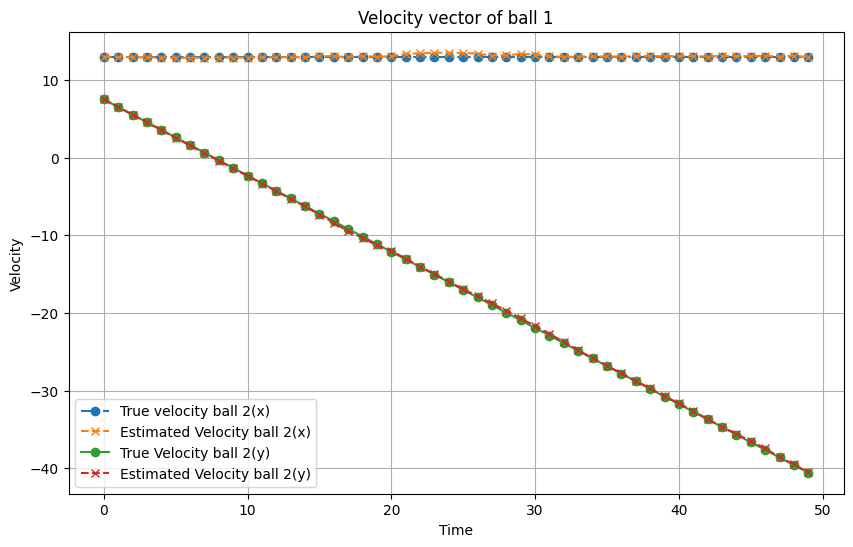

In [22]:
# Plotting the results using matplotlib
# plotting the true velocities, and estimated velocities of ball 2

plt.figure(figsize=(10, 6))
plt.plot(range(len(true_velocities_ball2)), true_velocities_ball2[:, 0], label='True velocity ball 2(x)', linestyle='-.', marker='o')
plt.plot(range(len(true_velocities_ball2)), estimated_velocities_ball2[:, 0], label='Estimated Velocity ball 2(x)', linestyle='--', marker='x')
plt.plot(range(len(true_positions_ball2)), true_velocities_ball2[:, 1], label='True Velocity ball 2(y)', linestyle='-', marker='o')
plt.plot(range(len(true_velocities_ball2)), estimated_velocities_ball2[:, 1], label='Estimated Velocity ball 2(y)', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vector of ball 1')
plt.grid(True)
plt.show()